In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(0)

/tmp/ipykernel_3550791/1526901925.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/tscc/nfs/home/hsher/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
data = torch.cat((Multinomial(total_count = 100, probs = torch.tensor([ 0.2, 0.8])).sample([90]),
                (Multinomial(total_count = 100, probs = torch.tensor([ 0.7, 0.3])).sample([10])
                )))

N_dim = 2

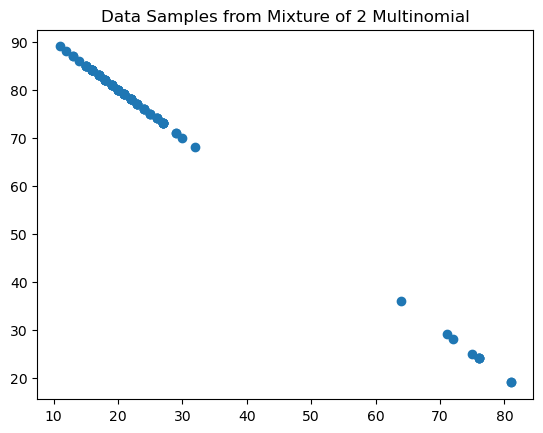

In [20]:
# data = torch.cat((MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50]),
#                   MultivariateNormal(8 * torch.ones(2), torch.eye(2)).sample([50]),
#                   MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(2)).sample([50]),
#                   MultivariateNormal(torch.tensor([-0.5, 1]), torch.eye(2)).sample([50])))

plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from Mixture of 2 Multinomial")
plt.show()
N = data.shape[0]

In [21]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)


In [31]:
Categorical(1)

AttributeError: 'int' object has no attribute 'dim'

In [49]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpyro.distributions as dist
#https://fehiepsi.github.io/rethinking-numpyro/12-monsters-and-mixtures.html
dist.Dirichlet(jnp.repeat(2, 7))

In [50]:
jnp.repeat(2, 7).sam

Array([2, 2, 2, 2, 2, 2, 2], dtype=int32, weak_type=True)

In [51]:
help(dist.Dirichlet)

Help on class Dirichlet in module numpyro.distributions.continuous:

class Dirichlet(numpyro.distributions.distribution.Distribution)
 |  Dirichlet(concentration, *, validate_args=None)
 |
 |  Method resolution order:
 |      Dirichlet
 |      numpyro.distributions.distribution.Distribution
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, concentration, *, validate_args=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  log_prob = wrapper(self, *args, **kwargs)
 |
 |  sample(self, key, sample_shape=())
 |      Returns a sample from the distribution having shape given by
 |      `sample_shape + batch_shape + event_shape`. Note that when `sample_shape` is non-empty,
 |      leading dimensions (of size `sample_shape`) of the returned sample will
 |      be filled with iid draws from the distribution instance.
 |
 |      :param jax.random.PRNGKey key: the rng_key key to be used for the distribution.
 |      :param tuple sample_shap

In [34]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    # with pyro.plate("mu_plate", T):
    #     mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))
    with pyro.plate("theta_plate", T):
        theta = pyro.sample("theta", Dirichlet(m = Dirichlet(torch.tensor(torch.ones(N_dim)))))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", Multinomial(100, theta[z], torch.eye(2)), obs=data)


In [40]:
def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    # tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))

    # This is different for Dirichlet, taking in 2 params
    tau_0 = pyro.param('tau_0', lambda: Uniform(0, 1).sample([T]), constraint=constraints.positive)
    
    #tau_1 = pyro.param('tau_1', lambda: LogNormal(-1, 1).sample([T]), constraint=constraints.positive)
    # logtheta_loc = docs.new_zeros((T, N_dim))
    # logtheta_scale = docs.new_ones((T, N_dim))
    
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("theta_plate", T):
        print(tau_0).shape
        q_theta = pyro.sample("theta", Dirichlet(m = Dirichlet(torch.tensor(torch.ones(N_dim)*tau_0))))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))



In [41]:
T = 6
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 0.1
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

alpha = 1.5
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
plt.tight_layout()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.4531, 0.3005, 0.6816, 0.7520, 0.0779, 0.2139],
       grad_fn=<AddBackward0>)


AttributeError: 'NoneType' object has no attribute 'shape'

In [7]:
# df = pd.read_csv('http://www.sidc.be/silso/DATA/SN_y_tot_V2.0.csv', sep=';', names=['time', 'sunspot.year'], usecols=[0, 1])
# data = torch.tensor(df['sunspot.year'].values, dtype=torch.float32).round()
# N = data.shape[0]

# plt.hist(df['sunspot.year'].values, bins=40)
# plt.title("Number of Years vs. Sunspot Counts")
# plt.xlabel("Sunspot Count")
# plt.ylabel("Number of Years")
# plt.show()

In [ ]:
https://nbviewer.org/github/pyro-ppl/pyro/blob/7f16042992d9ffe7dd4f16fa10d63008f807e0d4/tutorial/source/prodlda.ipynb#WordClouds